# DeepDream

In [78]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from keras.models import load_model
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  PIL.Image.resize
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

# We can try image from our test collection:

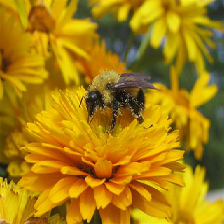

In [89]:
image_path = 'drive/MyDrive/SNR/kaggle_bee_vs_wasp/bee1/2984293_b650d46745_n.jpg'

img = image.load_img(image_path, target_size=(224, 224))
original_img = np.array(img)

show(original_img)

# ...or we can try some image from the Internet:

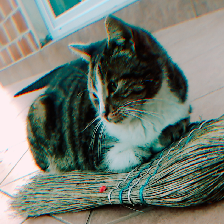

In [116]:
#url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
#original_img = download(url, max_dim=500)
#show(original_img)

image_path = 'drive/MyDrive/SNR/kot.png'

img = image.load_img(image_path, target_size=(224, 224))
original_img = np.array(img)

show(original_img)

# Original model with imagenet weights:

In [110]:
image_input = Input(shape=(224, 224, 3)) ### pre-define image imput dimension 224
base_model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet') #input_tensor=image_input, 
print('Model loaded.')
base_model.summary()

Model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128

# Our own trained models:

Choose one:

In [90]:
model_path = 'drive/MyDrive/SNR_modele/full_trained_model.h5'

In [95]:
model_path = 'drive/MyDrive/SNR_modele/full_trained_model_removed_layers.h5'

In [101]:
model_path = 'drive/MyDrive/SNR_modele/last_2_layers_trained_model.h5'

In [112]:
model_path = 'drive/MyDrive/SNR_modele/last_layer_trained_model.h5'

In [113]:
base_model = load_model(model_path)
print('Model ' + model_path + ' loaded.')
base_model.summary()

Model drive/MyDrive/SNR_modele/last_layer_trained_model.h5 loaded.
Model: "model_last_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________

# Choose layers to dreamify

In [114]:
# Maximize the activations of these layers
names = ['fc1']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# Calculate loss

In [83]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

# Gradient ascent

In [84]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [104]:
deepdream = DeepDream(dream_model)

## Main Loop

In [86]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)

  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

In [87]:
def octave(img):
  OCTAVE_SCALE = 1.0
  img = tf.constant(original_img)
  base_shape = tf.shape(img)[:-1]
  float_base_shape = tf.cast(base_shape, tf.float32)

  for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()
    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

  display.clear_output(wait=True)
  img = tf.image.resize(img, base_shape)
  img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
  show(img)

## Results


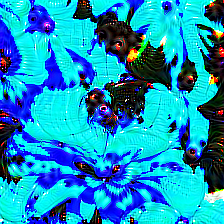

In [88]:
# original vgg16
octave(img)

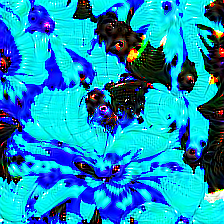

In [93]:
# full trained model
octave(img)

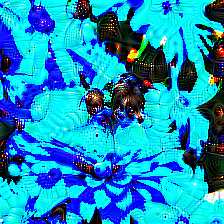

In [100]:
# full_trained_model_removed_layers
octave(img)

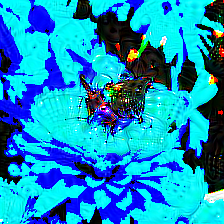

In [105]:
# last_2_layers_trained_model
octave(img)

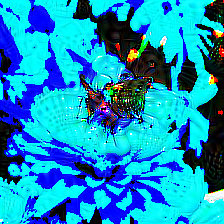

In [109]:
# last_layer_trained_model
octave(img)

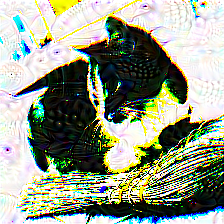

In [117]:
# Extra
# last_layer_trained_model
octave(img)